# WT partial differential equation

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the KdV equation. 

In [60]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
import colorcet as cc
import pandas as pd
from iteration_utilities import deepflatten

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from deepymod.analysis import load_tensorboard

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)

Data_File_Name      : str   = "Tr_G_WT_normalized_focused";
Noise_Proportion    : float = 0.1;
average_window = 5;
average_min_periods = 1;
rolling_average_type = 'gaussian';
sigma_space = 4;
nb_x_points = 252;
nb_t_points = 242;
time_born_change : bool = True;
time_frame_start : int = 30;
time_frame_end : int = 128;

normalize_signal : bool = True;

# Configuring GPU or CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)
#device = "cpu"

def write_model_expression(model_estimator_coeffs, poly_order=2, diff_order=3, latex=False):
    poly_order_it_array = range(1,poly_order+1)
    diff_order_it_array = range(1,diff_order+1)
    poly_terms = ['1']
    diff_terms = ['1']
    diff_term = 'u_{'
    for diff_order_it in diff_order_it_array:
        diff_term = diff_term + 'x'
        full_diff_term = diff_term +'}'
        diff_terms.append(full_diff_term)
    for poly_order_it in poly_order_it_array:
        if poly_order_it==1:
            poly_term = 'u'
        else:
            poly_term = 'u^{' + str(poly_order_it)+'}'
        poly_terms.append(poly_term)
    function_coeffs_list = library_matrix_mat(poly_terms, diff_terms)
    print('all tested functions list:')
    print(function_coeffs_list)
    print('--------------------------------------------------------')
    print('Inferred equation:')
    PDE_string = print_PDE(model_estimator_coeffs, function_coeffs_list, PDE_term='u_t')
    if latex is True:
        PDE_string = '$' + PDE_string + '$'
    return PDE_string

def library_matrix_mat(u, v, latex=False):
    '''
    Implements the matrix multiplication for strings and flattens it,
    mimicking how the library is made.
    Set latex=True to obtain latex forms.
    '''
    comp_list = []
    for u_element in u:
        for v_element in v:
            if ((u_element == '1') and ('v_element' == '1')):
                result = '1'
            elif u_element == '1':
                result = v_element
            elif v_element == '1':
                result = u_element
            else:
                result = u_element + v_element
            comp_list.append(result)
    if latex is True:
        comp_list = list(map(lambda x: '$'+x+'$', comp_list))
    return comp_list


def print_PDE(sparse_vector, coeffs_list, PDE_term='u_t'):
    '''
    Prints PDE with non-zero components according to sparse_vector.
    Set PDE_term to different string for different equations.
    '''
    non_zero_idx = np.nonzero(sparse_vector)[0]
    PDE = PDE_term + ' = '
    for idx in non_zero_idx:
        if idx != 0:
            if np.sign(sparse_vector[idx]) == -1:
                PDE += ' - '
            else:
                PDE += ' + '
            PDE += '%.4f ' % np.abs(sparse_vector[idx]) + coeffs_list[idx]
        else:
            PDE += '%.4f ' % np.abs(sparse_vector[idx])  
    print(PDE)
    return PDE

def write_model_expression(model_estimator_coeffs, poly_order=2, diff_order=3, latex=False):
    poly_order_it_array = range(1,poly_order+1)
    diff_order_it_array = range(1,diff_order+1)
    poly_terms = ['1']
    diff_terms = ['1']
    diff_term = 'u_{'
    for diff_order_it in diff_order_it_array:
        diff_term = diff_term + 'x'
        full_diff_term = diff_term +'}'
        diff_terms.append(full_diff_term)
    for poly_order_it in poly_order_it_array:
        if poly_order_it==1:
            poly_term = 'u'
        else:
            poly_term = 'u^{' + str(poly_order_it)+'}'
        poly_terms.append(poly_term)
    function_coeffs_list = library_matrix_mat(poly_terms, diff_terms)
    print('all tested functions list:')
    print(function_coeffs_list)
    print('--------------------------------------------------------')
    print('Inferred equation:')
    PDE_string = print_PDE(model_estimator_coeffs, function_coeffs_list, PDE_term='u_t')
    if latex is True:
        PDE_string = '$' + PDE_string + '$'
    return PDE_string

def library_matrix_mat(u, v, latex=False):
    '''
    Implements the matrix multiplication for strings and flattens it,
    mimicking how the library is made.
    Set latex=True to obtain latex forms.
    '''
    comp_list = []
    for u_element in u:
        for v_element in v:
            if ((u_element == '1') and ('v_element' == '1')):
                result = '1'
            elif u_element == '1':
                result = v_element
            elif v_element == '1':
                result = u_element
            else:
                result = u_element + v_element
            comp_list.append(result)
    if latex is True:
        comp_list = list(map(lambda x: '$'+x+'$', comp_list))
    return comp_list


def print_PDE(sparse_vector, coeffs_list, PDE_term='u_t'):
    '''
    Prints PDE with non-zero components according to sparse_vector.
    Set PDE_term to different string for different equations.
    '''
    non_zero_idx = np.nonzero(sparse_vector)[0]
    PDE = PDE_term + ' = '
    for idx in non_zero_idx:
        if idx != 0:
            if np.sign(sparse_vector[idx]) == -1:
                PDE += ' - '
            else:
                PDE += ' + '
            PDE += '%.4f ' % np.abs(sparse_vector[idx]) + coeffs_list[idx]
        else:
            PDE += '%.4f ' % np.abs(sparse_vector[idx])  
    print(PDE)
    return PDE

def signal_space_derivative(signal_matrix : pd.DataFrame(),
                            nb_nx_points : int,average_window : int,
                            average_min_periods :int,
                            sigma_space :int,
                            rolling_average_type : str = 'gaussian'):
    signal_matrix_dx = signal_matrix.copy()
    nx_dx = signal_matrix_dx['nx'].iloc[:-1]
    signal_matrix_dx = signal_matrix_dx.diff()
    signal_matrix_dx['nx_delta'] = signal_matrix_dx['nx']*0.5
    for column in signal_matrix_dx.columns:
        signal_matrix_dx.loc[:,column] = signal_matrix_dx.loc[:,column]/signal_matrix_dx.loc[:,'nx']
    signal_matrix_dx.dropna(inplace=True)
    signal_matrix_dx.reset_index(drop=True, inplace=True)
    signal_matrix_dx['nx'] = nx_dx + signal_matrix_dx['nx_delta']
    signal_matrix_dx.drop(['nx_delta'], axis=1, inplace=True)
    min_nx_dx = signal_matrix_dx['nx'].min()
    max_nx_dx = signal_matrix_dx['nx'].max()
    nx_dx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
    signal_matrix_dx_averaged = pd.DataFrame()
    signal_matrix_dx_averaged['nx'] = nx_dx_linearized
    signal_matrix_dx_averaged_temporal = signal_matrix_dx.copy()
    signal_matrix_dx_averaged_temporal.drop(['nx'], axis=1, inplace=True)
    for column in signal_matrix_dx_averaged_temporal.columns:
        ny = np.interp(nx_dx_linearized,signal_matrix_dx['nx'],signal_matrix_dx_averaged_temporal[column])
        signal_matrix_dx_averaged[column] = ny
        signal_matrix_dx_averaged[column] = signal_matrix_dx_averaged[column].rolling(window = average_window,
                                                                                           min_periods = average_min_periods,
                                                                                           win_type = rolling_average_type).mean(std = sigma_space)
    signal_matrix_dx_averaged['nx'] = signal_matrix_dx_averaged.loc[:,'nx'].rolling(window = average_window, min_periods = average_min_periods, center=True).mean()
    signal_matrix_dx_averaged = signal_x_common_base(signal_matrix_dx_averaged,'nx',
                                                     signal_matrix_dx_averaged['nx'].min(),
                                                     signal_matrix_dx_averaged['nx'].max(),
                                                     nb_nx_points)
    return signal_matrix_dx_averaged

def signal_time_derivative(signal_matrix : pd.DataFrame(),
                           nb_dt_points : int,
                           average_window : int,
                           average_min_periods : int,
                           sigma_time : int,
                           rolling_average_type : str = 'gaussian'):
    # time derivative
    signal_matrix_dt = signal_matrix.copy()
    nt_dt = signal_matrix_dt['nt'].iloc[:-1]
    nt_dt.reset_index(drop=True, inplace=True)
    signal_matrix_dt = signal_matrix_dt.diff()
    signal_matrix_dt['nt_delta'] = signal_matrix_dt['nt'] * 0.5
    for column in signal_matrix_dt.columns:
        signal_matrix_dt.loc[:,column] = signal_matrix_dt.loc[:,column]/signal_matrix_dt.loc[:,'nt']
    signal_matrix_dt.dropna(inplace=True)
    signal_matrix_dt.reset_index(drop=True, inplace=True)
    signal_matrix_dt['nt'] = nt_dt + signal_matrix_dt['nt_delta']
    signal_matrix_dt.drop(['nt_delta'], axis=1, inplace=True)
    min_nt_dt = signal_matrix_dt['nt'].min()
    max_nt_dt = signal_matrix_dt['nt'].max()
    nt_dt_linearized = np.linspace(min_nt_dt, max_nt_dt, nb_dt_points)
    signal_matrix_dt_averaged = pd.DataFrame()
    signal_matrix_dt_averaged_temporal = signal_matrix_dt.copy()
    signal_matrix_dt_averaged_temporal.drop(['nt'], axis=1, inplace=True)
    signal_matrix_dt_averaged['nt'] = nt_dt_linearized
    for column in signal_matrix_dt_averaged_temporal.columns:
        ny = np.interp(nt_dt_linearized,signal_matrix_dt['nt'],signal_matrix_dt_averaged_temporal[column])
        signal_matrix_dt_averaged[column] = ny
        signal_matrix_dt_averaged[column] = signal_matrix_dt_averaged[column].rolling(window = average_window,
                                                                                           min_periods = average_min_periods,
                                                                                           win_type = rolling_average_type).mean(std = sigma_time)
    signal_matrix_dt_averaged['nt'] = signal_matrix_dt_averaged.loc[:,'nt'].rolling(window = average_window,
                                                                                    min_periods = average_min_periods,
                                                                                    center=True).mean()
    signal_matrix_dt_averaged = signal_x_common_base(signal_matrix_dt_averaged,'nt',
                                                     signal_matrix_dt_averaged['nt'].min(),
                                                     signal_matrix_dt_averaged['nt'].max(),
                                                     nb_dt_points)
    return signal_matrix_dt_averaged

def signal_x_common_base(signal_matrix_space : pd.DataFrame(), ref_coordinates_column : str, min_nx_dx : float, max_nx_dx : float, nb_nx_points : int):
    signal_matrix_interpolated_temporal = signal_matrix_space.copy()
    nx_dx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
    signal_matrix_interpolated = pd.DataFrame()
    signal_matrix_interpolated[ref_coordinates_column] = nx_dx_linearized
    signal_matrix_interpolated_temporal.drop([ref_coordinates_column], axis=1, inplace=True)
    for column in signal_matrix_interpolated_temporal.columns:
        ny = np.interp(nx_dx_linearized, signal_matrix_space[ref_coordinates_column], signal_matrix_interpolated_temporal[column])
        signal_matrix_interpolated[column] = ny
    return signal_matrix_interpolated


def signal_t_common_base(signal_matrix_time : pd.DataFrame(), ref_coordinates_column : str, min_nt_dt : float, max_nt_dt : float, nb_nx_points : int):
    signal_matrix_interpolated_temporal = signal_matrix_time.copy()
    nt_dt_linearized = np.linspace(min_nt_dt, max_nt_dt, nb_nt_points)
    signal_matrix_interpolated = pd.DataFrame()
    signal_matrix_interpolated[ref_coordinates_column] = nt_dt_linearized
    signal_matrix_interpolated_temporal.drop([ref_coordinates_column], axis=1, inplace=True)
    for column in signal_matrix_interpolated_temporal.columns:
        ny = np.interp(nt_dt_linearized, signal_matrix_time[ref_coordinates_column], signal_matrix_interpolated_temporal[column])
        signal_matrix_interpolated[column] = ny
    return signal_matrix_interpolated


def plot_signal_space_derivative_fixed_time(signal_matrix_space : pd.DataFrame(),ref_time_label_df : pd.DataFrame(), quantity : str, derivative_label : str,   angle : float,
                                            start_frame: int, end_frame : int, delta_t : int, chi_threshold : float,
                                            plot_factor : float, ratio : float, axes_limitis_manual = False, y_min_manual = False, y_max_manual = False, FIGURES_DIR = ''):
    figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
    angle = np.round(angle, decimals = 3)
    label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
    title = 'signal ' + quantity + ', '+ label
    cmap = cc.cm.CET_CBTL2
    colors = cmap(np.linspace(0,1,int((end_frame  - start_frame + 1) / delta_t)))
    for time_frame,color in zip(range(start_frame,end_frame ,delta_t),colors):
            frame = 't' + str(time_frame)
            signal = signal_matrix_space.loc[:,signal_matrix_space.columns.str.endswith(frame) | signal_matrix_space.columns.str.contains('nx')].copy()
            signal = signal[(signal['nx']>chi_threshold)]
            plt.plot(signal['nx'], signal[quantity+'_r_avrg_'+ frame],c=color,label = ref_time_label_df.iloc[time_frame]['time_label']+' APF')
    plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
    ax.set(xlabel = r'$\chi$', ylabel = r'$ %s \equiv F(\chi|t)$' % derivative_label)
    if axes_limitis_manual:
        ax.set_ylim(y_min_manual, y_max_manual)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
    plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
    ax.legend(loc='center left', bbox_to_anchor=(0.81, 0.5))
    if FIGURES_DIR != '':
        plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
    plt.show()

def plot_signal_time_derivative_fixed_space(signal_matrix_time : pd.DataFrame(),ref_space_label_df : pd.DataFrame(), quantity : str, derivative_label : str,   angle : float,
                                            start_chi_column: int, end_chi_column : int, delta_chi : int, t_threshold : float,
                                            plot_factor : float, ratio : float, axes_limitis_manual = False, y_min_manual = False, y_max_manual = False, FIGURES_DIR = ''):
    figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
    angle = np.round(angle, decimals = 3)
    label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
    title = 'signal ' + quantity + ', '+ label
    cmap = cc.cm.CET_CBTL2
    colors = cmap(np.linspace(0,1,int((end_chi_column  - start_chi_column + 1) / delta_chi)))
    for chi_column,color in zip(range(start_frame,end_frame ,delta_t),colors):
        signal = signal_matrix_time[(signal_matrix_time['nt']>t_threshold)]
        plt.plot(signal.loc[:,'nt'], signal.loc[:,chi_column],c=color,label = r'%s $\mu$' %str(np.round(ref_space_label_df.loc[chi_column,'nx'],decimals = 1)))
    plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
    ax.set(xlabel = r'$t(hAPF)$', ylabel = r'$ %s \equiv F(t|\chi)$' % derivative_label)
    if axes_limitis_manual:
        ax.set_ylim(y_min_manual, y_max_manual)
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
    plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
    ax.legend(loc='center left', bbox_to_anchor=(0.81, 0.5))
    if FIGURES_DIR != '':
        plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
    plt.show()
    
def signal_rebase(matrix : pd.DataFrame(), x_ref : np.array(()), t_ref : np.array(()), nb_x : int, nb_t : int, average_window_characteristics):
    average_window = average_window_characteristics[0];
    average_min_periods = 1;
    rolling_average_type = 'gaussian';
    sigma_space = average_window_characteristics[3];
    matrix_interpolated_temporal = matrix.copy();
    matrix_interpolated_temporal.reset_index(drop=True, inplace=True);
    x_min = x_ref.min();
    x_max = x_ref.max();
    print('x_min:',x_min);
    print('x_max:',x_max);
    t_min = t_ref.min();
    t_max = t_ref.max();
    print('t_min:',x_min);
    print('t_max:',x_max);
    x_new = np.linspace(x_min, x_max, nb_x);
    t_new = np.linspace(t_min, t_max, nb_t);
    matrix_temporal = [];
    for column in range(matrix_interpolated_temporal.columns.size):
        ny = np.interp(x_new, x_ref, matrix_interpolated_temporal[column]);
        matrix_temporal.append(ny);
    matrix_temporal_df = pd.DataFrame(matrix_temporal);
    matrix_temporal_df.rolling(window = average_window,
                               min_periods = average_min_periods,
                               win_type = rolling_average_type).mean(std = sigma_space);
    matrix_temporal = [];
    for column in range(matrix_temporal_df.columns.size):
        ny = np.interp(t_new, t_ref, matrix_temporal_df[column]);
        matrix_temporal.append(ny);
    matrix_new = pd.DataFrame(matrix_temporal);
    matrix_new.rolling(window = average_window,
                       min_periods = average_min_periods,
                       win_type = rolling_average_type).mean(std = sigma_space);
    return x_new, t_new, matrix_new    

cuda


Shape of grid x: (140, 176)
Shape of grid t: (140, 176)
Shape of grid u: (140, 176)


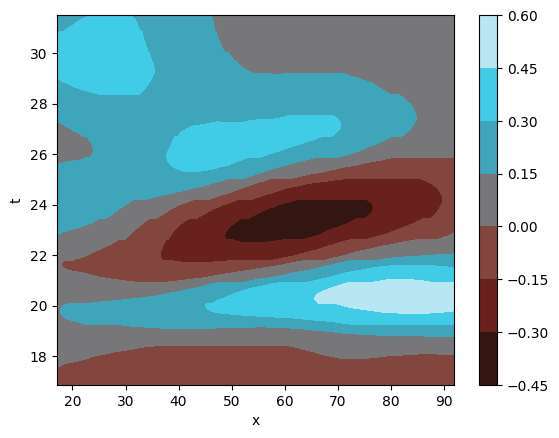

In [3]:
signal_data = pd.read_csv('dataset/signal_matrix_space_data.csv')
time_data = pd.read_csv('dataset/plot_time_label_df.csv')
x = signal_data['nx'].values
t = time_data['frame_in_hours'].values
t,x = np.meshgrid(t,x)
u_data = signal_data.copy()
u_data = u_data.drop(columns=['nx'])
u = np.real(u_data.to_numpy())*10
data = {}
data['x'] = x
print('Shape of grid x:', data['x'].shape)
data['t'] = t
print('Shape of grid t:', data['t'].shape)
data['u'] = u 
print('Shape of grid u:', data['u'].shape)

fig, ax = plt.subplots()
im = ax.contourf(data['x'], data['t'], data['u'], cmap=cc.cm.CET_CBTL2)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()


In [4]:
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))
print('X shape, y shape:', X.shape, y.shape)

X shape, y shape: (24640, 2) (24640, 1)


In [5]:
noise_level = 0.025
y_noisy = y + noise_level * np.std(y) * np.random.randn(y[:,0].size, 1)
#coords = torch.from_numpy(np.stack((t.tolist(),x.tolist()), axis=-1)).float()
#X = coords
#y = u

In [6]:
number_of_samples = 5000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)
print(X_train.shape, y_train.shape)

torch.Size([5000, 2]) torch.Size([5000, 1])


In [7]:
len(idx)

24640

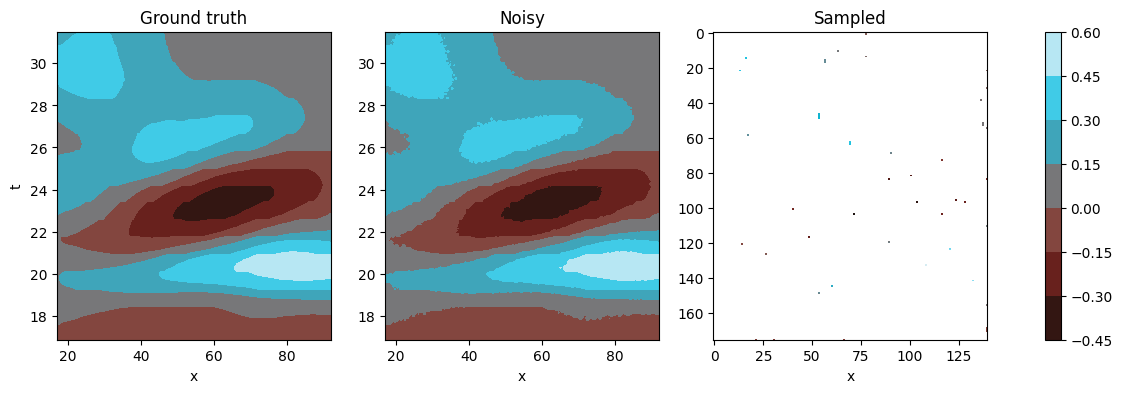

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap=cc.cm.CET_CBTL2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap=cc.cm.CET_CBTL2)
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap=cc.cm.CET_CBTL2)
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

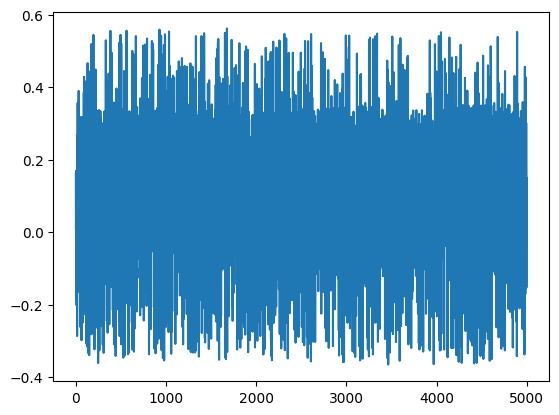

In [9]:
plt.plot(y_train)

Before we send the data into the Dataset format, create a plot to get an idea of the data:

x shape, u shape: (140, 85) (140, 85)


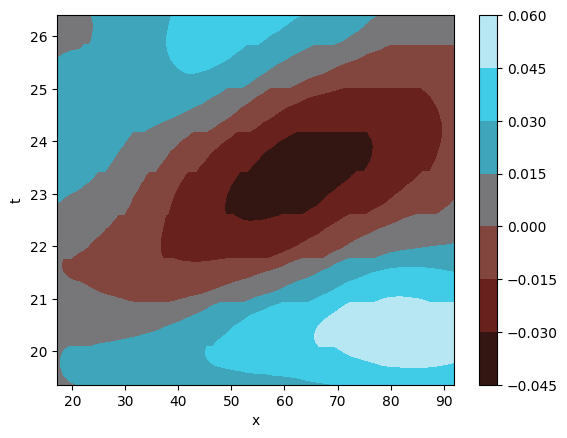

In [10]:
signal_data = pd.read_csv('dataset/signal_matrix_space_data.csv')
x = np.real(signal_data['nx'].values)
t = time_data['frame_in_hours'].values
t_min = int(30)
t_max = int(115)
u_data = signal_data.copy()
u_data = u_data.drop(columns=['nx'])
u_data = u_data.iloc[:,t_min:t_max]
t = np.real(t[t_min:t_max])
u = np.real(u_data.to_numpy())
t,x = np.meshgrid(t,x)
print('x shape, u shape:', x.shape, u.shape)
fig, ax = plt.subplots()
im = ax.contourf(x, t, u, cmap=cc.cm.CET_CBTL2)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()


In [ ]:
CURRENT_PATH = os.getcwd()

def main():
    # Specify settings.
    Data_File_Name      : str   = "Tr_G_WT_normalized_focused";
    Noise_Proportion    : float = 0.1;

    Num_Train_Examples  : int   = 5000;
    Num_Test_Examples   : int   = 1000;

    average_window = 5;
    average_min_periods = 1;
    rolling_average_type = 'gaussian';
    sigma_space = 4;
    nb_x_points = 252;
    nb_t_points = 242;
    time_born_change : bool = True;
    time_frame_start : int = 30;
    time_frame_end : int = 128;

    normalize_signal : bool = True;

    # Now pass them to "From_MATLAB".
    From_Morphogenesis(    Data_File_Name      = Data_File_Name,
                           Noise_Proportion    = Noise_Proportion,
                           Num_Train_Examples  = Num_Train_Examples,
                           Num_Test_Examples   = Num_Test_Examples,
                           average_window = average_window,
                           average_min_periods = average_min_periods,
                           rolling_average_type = rolling_average_type,
                           sigma_space = sigma_space,
                           nb_x_points = nb_x_points,
                           nb_t_points = nb_t_points,
                           time_born_change = time_born_change,
                           time_frame_start = time_frame_start,
                           time_frame_end = time_frame_end,
                           normalize_signal = normalize_signal);



def From_Morphogenesis(    Data_File_Name      : str,
                           Noise_Proportion    : float,
                           Num_Train_Examples  : int,
                           Num_Test_Examples   : int,
                           average_window      : int,
                           average_min_periods : int,
                           rolling_average_type: str,
                           sigma_space         : float,
                           nb_x_points         : int,
                           nb_t_points         : int,
                           time_born_change    : bool,
                           time_frame_start    :int,
                           time_frame_end      :int,
                           normalize_signal    :bool) -> None:
    """ This function loads a .mat data set, and generates a sparse and noisy
    data set from it. To do this, we first read in a .mat data set. We assume
    this file  contains three fields: t, x, and usol. t and x are ordered lists
    of the x and t grid lines (lines along which there are gridpoints),
    respectively. We assume that the values in x are uniformly spaced. u sol
    contains the value of the true solution at each gridpoint. Each row of usol
    contains the solution for a particular position, while each column contains
    the solution for a particular time.

    We then add the desired noise level (Noise_Proportion*100% noise) to usol,
    yielding a noisy data set. Next, we draw a sample of Num_Train_Examples
    from the set of coordinates, along with the corresponding elements of noisy
    data set. This becomes our Training data set. We draw another sample of
    Num_Test_Examples from the set of coordinates along with the
    corresponding elements of the noisy data set. These become our Testing set.

    Note: This function is currently hardcoded to work with data involving 1
    spatial dimension.

    ----------------------------------------------------------------------------
    Arguments:

    Data_File_Name: A string containing the name of a .mat file (without the
    extension) that houses the matlab data set we want to read.

    Noise_Proportion: The noise level we want to introduce.

    Num_Train_Examples, Num_Test_Examples: The number of Training/Testing
    examples we want, respectively.

    ----------------------------------------------------------------------------
    Returns:

    Nothing! """

    # Load data file.
    Data_Set_Signal_Path  = "../morphogenesis/dataset_experiment/signal_matrix_space_data.csv";
    signal_data = pd.read_csv(Data_Set_Signal_Path);
    Data_Set_Time_Path  = "../morphogenesis/dataset_experiment/plot_time_label_df.csv";
    time_data = pd.read_csv(Data_Set_Time_Path);
    space_coordinate = np.squeeze(signal_data['nx'].values);
    print('Shape of grid space_coordinate:', space_coordinate.shape);
    time_coordinate = time_data['frame_in_hours'].values;
    u_data = signal_data.copy();
    u_data = u_data.drop(columns=['nx']);
   
    if time_born_change: 
        time_coordinate = time_coordinate[time_frame_start:time_frame_end];
        u_data = u_data.iloc[:,time_frame_start:time_frame_end].copy();
    print('Shape of grid u_data:', u_data.shape);
    time_coordinate_offset = time_coordinate.min();
    time_coordinate = time_coordinate - time_coordinate_offset;
    space_coordinate_offset = space_coordinate.min();
    space_coordinate = space_coordinate - space_coordinate_offset;
    print('Shape of grid time_coordinate:', time_coordinate.shape);
    #resize the input data to 'nb_x_points'x'nb_t_points'
    average_window_characteristics = [average_window, 
                                      average_min_periods,
                                      rolling_average_type,
                                      sigma_space];
    u_data_copy = u_data.copy();
    u_data_copy.columns = range(u_data_copy.shape[1]);
    u_data_copy.reset_index(drop=True, inplace=True);

    x_new, t_new, u_new = signal_rebase(u_data_copy,
                                        space_coordinate,
                                        time_coordinate,
                                        nb_x_points,
                                        nb_t_points,
                                        average_window_characteristics);
    if normalize_signal:
        u_new_min = u_new.min().min();
        u_new_max = u_new.max().max();
        u_new_normalized = (u_new - u_new_min)/(u_new_max - u_new_min)*2-1;
        u_new = u_new_normalized;
    t,x = np.meshgrid(t_new,x_new);
    print('Shape of grid u_data resized:',  u_new.shape);
    data_in = {};
    data_in['t'] = t;
    print('Shape of grid t:', data_in['t'].shape);
    data_in['x'] = x;
    print('Shape of grid x:', data_in['x'].shape);
    data_in['u'] = u_new;
    print('Shape of grid u:', data_in['u'].shape);

    # Fetch spatial, temporal coordinates and the true solution. We cast these
    # to singles (32 bit fp) since that's what PDE-REAd uses.
    t_points    =  t_new.reshape(-1).astype(dtype = np.float32);
    print('number t points:',t_points.shape[0])
    x_points    =  x_new.reshape(-1).astype(dtype = np.float32);
    print('number x points:',x_points.shape[0])
    Data_Set    = (np.real(u_new)).astype( dtype = np.float32);
    print('number points Data_Set:',Data_Set.shape)

    # Determine problem bounds.
    Input_Bounds : np.ndarray    = np.empty(shape = (2, 2), dtype = np.float32);
    Input_Bounds[0, 0]              = t_points[ 0];
    Input_Bounds[0, 1]              = t_points[-1];
    Input_Bounds[1, 0]              = x_points[ 0];
    Input_Bounds[1, 1]              = x_points[-1];

    # Add noise to true solution.
    Noisy_Data_Set = Data_Set + (Noise_Proportion)*np.std(Data_Set)*np.random.randn(*Data_Set.shape);

    # Generate the grid of (t, x) coordinates where we'll enforce the "true
    # solution". Each row of these arrays corresponds to a particular position.
    # Each column corresponds to a particular time.
    t_coords_matrix, x_coords_matrix  = np.meshgrid(t_points, x_points);
    print('number points Noisy_Data_Set:', Noisy_Data_Set.shape)

    if(Make_Plot == True):
        epsilon : float = .0001;
        Data_min : float = np.min(Noisy_Data_Set) - epsilon;
        Data_max : float = np.max(Noisy_Data_Set) + epsilon;

        # Plot!
        plt.contourf(    t_coords_matrix,
                            x_coords_matrix,
                            Noisy_Data_Set,
                            levels      = np.linspace(Data_min, Data_max, 500),
                            cmap        = plt.cm.jet);

        plt.colorbar();
        plt.xlabel("t");
        plt.ylabel("x");
        plt.show();

        Data_min : float = np.min(Data_Set);
        Data_max : float = np.max(Data_Set);
        plt.contourf(       t_coords_matrix,
                            x_coords_matrix,
                            Data_Set,
                            levels      = np.linspace(Data_min, Data_max, 500),
                            cmap        = plt.cm.jet);

        plt.colorbar();
        plt.xlabel("t");
        plt.ylabel("x");
        plt.show();
        
    save_rescaled_data_file_name = DataSet_Name + ".hdf5";
    if os.path.isfile(os.path.join(CURRENT_PATH,"DataSets",save_rescaled_data_file_name)):
        os.remove(os.path.join(CURRENT_PATH,"DataSets",save_rescaled_data_file_name));
    os.chdir(os.path.join(CURRENT_PATH,"DataSets"));                                   
    outfile = h5py.File(save_rescaled_data_file_name , 'w');
    outfile.close();
    outfile =  h5py.File(save_rescaled_data_file_name , 'w');
    outfile.create_dataset('t', data = t_new);
    outfile.create_dataset('x', data = x_new);
    outfile.create_dataset('u', data = u_new);
    outfile.close();
    os.chdir(CURRENT_PATH);

We can now define a function that loads the data, makes torch tensors out of it and then returns it in a coords, data format. The shape of the samples will be (t,x) for the input and (u) for the dataset. Ensure that any array is not 1D, so an array with a single feature can be the shape (N,1) using reshape(-1,1) in numpy or unsqueeze(-1) in torch.

In [11]:
def load_data():
    coords = torch.from_numpy(np.stack((t.tolist(),x.tolist()), axis=-1)).float()
    data = torch.from_numpy(u).unsqueeze(-1).float()
    return coords, data

In [12]:
xt = torch.from_numpy(np.stack((t.tolist(),x.tolist()), axis=-1)).float()
ut = torch.from_numpy(u).unsqueeze(-1).float()
#xt.shape
ut.shape

torch.Size([140, 85, 1])

In [13]:
140*85

11900

In [15]:
dataset = Dataset(
    load_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 5000},
    device=device,
)

Dataset is using device:  cuda


We now also wish to split the data into a train and test split, specifically into loaders, which handle the logic of passing the samples to the model.

In [16]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.


In [17]:
network = NN(2, [60, 60, 60, 60], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [18]:
library = Library1D(poly_order=2, diff_order=3) 

In [153]:
from deepymod.model.library import library_poly
from deepymod.model.library import library_deriv
library_poly = library_poly(y_train,2)
#library_deriv = library_deriv(load_data_test[0],load_data_test[1],3)

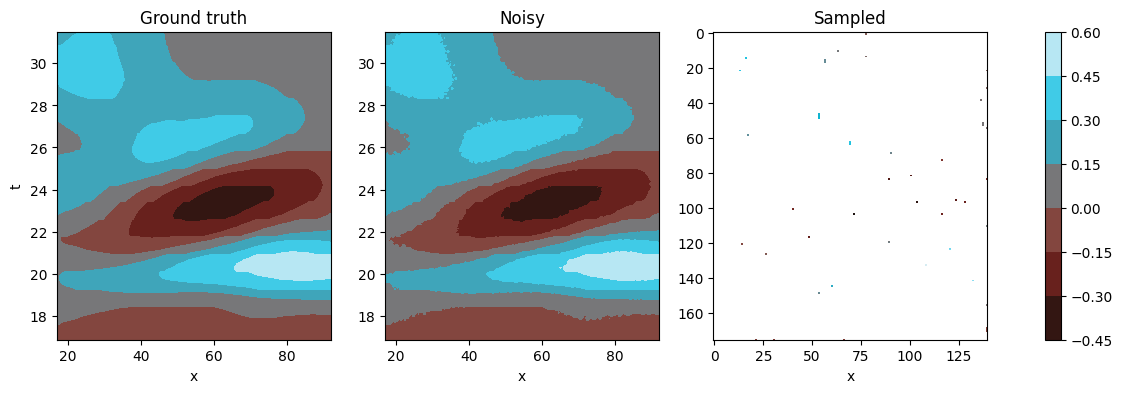

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap=cc.cm.CET_CBTL2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap=cc.cm.CET_CBTL2)
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap=cc.cm.CET_CBTL2)
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged. 

In [ ]:
estimator = Threshold(0.1)
#estimator = PDEFIND()
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5)

Configuration of the sparsity estimator

In [44]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

In [45]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data:

- The directory where the tensorboard file is written (log_dir)
- The ratio of train/test set used (split)
- The maximum number of iterations performed (max_iterations)
- The absolute change in L1 norm considered converged (delta)
- The amount of epochs over which the absolute change in L1 norm is calculated (patience)



In [46]:
train(model, train_dataloader, test_dataloader, optimizer, sparsity_scheduler, log_dir='runs/test_05/', split=0.8, max_iterations=100000)

   875  MSE: 3.81e-04  Reg: 2.33e-06  L1: 9.39e-01 

KeyboardInterrupt: 

In [24]:
model_sparsity_masks = model.sparsity_masks

In [25]:
model_estimator_coeffs = model.estimator_coeffs()

There's two groups: the model.estimator_coeffs() are the coefficients as returned by the sparsity estimator, and are always normalized. The model.constraint_coeffs() return the coefficients as calculated by the constraint through least squares typically. scaled sets if theyre normalized, sparse sets if you also want the zeros returned.

In [26]:
print(model_estimator_coeffs[0])

[[ 0.       ]
 [-0.8007889]
 [ 0.       ]
 [ 0.       ]
 [-0.1337409]
 [-0.1959347]
 [ 0.       ]
 [ 0.       ]
 [ 0.       ]
 [ 0.       ]
 [ 0.       ]
 [ 0.       ]]


In [27]:
PDE_string = write_model_expression(model_estimator_coeffs[0], poly_order=2, diff_order=3, latex=False)

all tested functions list:
['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'uu_{x}', 'uu_{xx}', 'uu_{xxx}', 'u^{2}', 'u^{2}u_{x}', 'u^{2}u_{xx}', 'u^{2}u_{xxx}']
--------------------------------------------------------
Inferred equation:
u_t =  - 0.8008 u_{x} - 0.1337 u - 0.1959 uu_{x}


In [ ]:
u_t = 0.5136  - 1.0543 u_{x} + 0.2469 u_{xxx} + 0.2161 uu_{x} + 1.2915 uu_{xx} - 0.6074 u^{2}u_{x} + 0.2985 u^{2}u_{xxx}

In [28]:
model_constraint_coeffs = model.constraint_coeffs()

In [29]:
print(model_constraint_coeffs)

[tensor([[ 0.0000],
        [-3.1620],
        [ 0.0000],
        [ 0.0000],
        [-0.0516],
        [-5.7799],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]


In [147]:
train_dataloader[0]

(tensor([[26.3167, 24.0825],
         [19.5500, 31.0801],
         [23.2500, 59.6086],
         ...,
         [21.0333, 87.5988],
         [23.3500, 74.1419],
         [21.4000, 29.4653]], device='cuda:0'),
 tensor([[ 0.1518],
         [ 0.2015],
         [-0.3601],
         ...,
         [ 0.4305],
         [-0.2857],
         [-0.0485]], device='cuda:0'))

In [139]:
train_dataloader.dataset[2]

(tensor([23.2500, 59.6086], device='cuda:0'),
 tensor([-0.3601], device='cuda:0'))

In [148]:
test_dataloader[0]

(tensor([[20.0167, 61.2234],
         [25.3833, 84.3691],
         [24.9167, 87.0605],
         ...,
         [23.0667, 26.7739],
         [23.9000, 70.3740],
         [21.6833, 76.8333]], device='cuda:0'),
 tensor([[ 0.3923],
         [-0.0847],
         [-0.1488],
         ...,
         [ 0.0907],
         [-0.3366],
         [ 0.2409]], device='cuda:0'))

In [144]:
dataset[0]

(tensor([24.0833, 74.1419], device='cuda:0'),
 tensor([-0.3146], device='cuda:0'))

## Analysing

In [47]:
# right now works with file path, will change to experiment_ID 
df =  load_tensorboard('runs/test_05/')

In [48]:
df.head()

,estimator_coeffs_output_0,loss_mse_output_0,coeffs_output_0_coeff_0,coeffs_output_0_coeff_1,coeffs_output_0_coeff_10,coeffs_output_0_coeff_11,coeffs_output_0_coeff_2,coeffs_output_0_coeff_3,coeffs_output_0_coeff_4,coeffs_output_0_coeff_5,...,estimator_coeffs_output_0_coeff_11,estimator_coeffs_output_0_coeff_2,estimator_coeffs_output_0_coeff_3,estimator_coeffs_output_0_coeff_4,estimator_coeffs_output_0_coeff_5,estimator_coeffs_output_0_coeff_6,estimator_coeffs_output_0_coeff_7,estimator_coeffs_output_0_coeff_8,estimator_coeffs_output_0_coeff_9,loss_l1_output_0
0,0.000000,0.005535,0.698955,0.156789,0.075404,0.658794,-0.618911,-0.000417,2.176095,2.608606,...,0.136939,-0.386818,-0.119236,0.602413,1.386280,0.000000,0.000000,0.484381,0.786789,10.955513
25,1.868572,0.000498,2.242497,-0.978122,-0.747016,0.247518,-0.821928,0.032192,-5.138330,0.754262,...,0.000000,-0.555755,0.000000,-4.365478,0.000000,0.818913,-0.125804,2.770931,-0.331702,16.588539
50,0.000000,0.000477,0.031303,-1.403069,-0.648416,-0.247140,-0.591947,-0.336819,-0.842822,1.196901,...,0.000000,-0.414260,-0.173524,-0.743126,0.854871,0.661949,0.000000,0.620413,-0.641165,8.443225
75,0.201140,0.000957,0.317083,0.742958,-1.639362,0.418440,-0.901977,0.622604,2.292796,3.313295,...,0.128818,0.000000,0.000000,1.495355,1.740818,-0.311750,0.429479,1.260329,0.678414,17.127125
100,0.205939,0.000957,0.521379,0.000000,-0.541031,0.135073,0.000000,0.000000,2.451342,2.054719,...,0.130167,0.000000,0.000000,1.506141,1.744177,-0.306974,0.431366,1.266838,0.679812,9.264874


In [49]:
df.keys()

Index(['estimator_coeffs_output_0', 'loss_mse_output_0',
       'coeffs_output_0_coeff_0', 'coeffs_output_0_coeff_1',
       'coeffs_output_0_coeff_10', 'coeffs_output_0_coeff_11',
       'coeffs_output_0_coeff_2', 'coeffs_output_0_coeff_3',
       'coeffs_output_0_coeff_4', 'coeffs_output_0_coeff_5',
       'coeffs_output_0_coeff_6', 'coeffs_output_0_coeff_7',
       'coeffs_output_0_coeff_8', 'coeffs_output_0_coeff_9',
       'loss_reg_output_0', 'unscaled_coeffs_output_0_coeff_0',
       'unscaled_coeffs_output_0_coeff_1', 'unscaled_coeffs_output_0_coeff_10',
       'unscaled_coeffs_output_0_coeff_11', 'unscaled_coeffs_output_0_coeff_2',
       'unscaled_coeffs_output_0_coeff_3', 'unscaled_coeffs_output_0_coeff_4',
       'unscaled_coeffs_output_0_coeff_5', 'unscaled_coeffs_output_0_coeff_6',
       'unscaled_coeffs_output_0_coeff_7', 'unscaled_coeffs_output_0_coeff_8',
       'unscaled_coeffs_output_0_coeff_9', 'estimator_coeffs_output_0_coeff_1',
       'estimator_coeffs_output_0_

Text(0.5, 1.0, 'Regression')

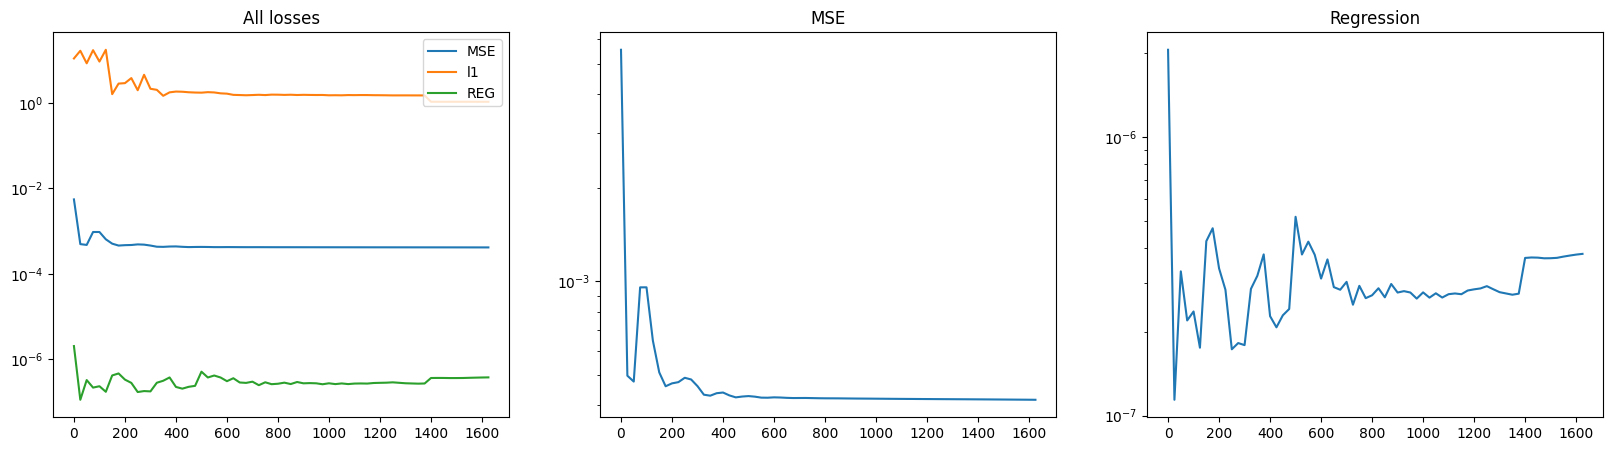

In [52]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.semilogy(df.index, df['loss_mse_output_0'], label='MSE')
plt.semilogy(df.index, df['loss_l1_output_0'], label='l1')
plt.semilogy(df.index, df['loss_reg_output_0'], label='REG')
plt.title('All losses')
plt.legend()

plt.subplot(132)
plt.semilogy(df.index, df['loss_mse_output_0'], label='MSE')
plt.title('MSE')

plt.subplot(133)
plt.semilogy(df.index, df['loss_reg_output_0'], label='PI')
plt.title('Regression')

In [53]:
coeff_keys = [key for key in df.keys() if key[:5]=='coeff']

Text(0.5, 1.0, 'Coefficients')

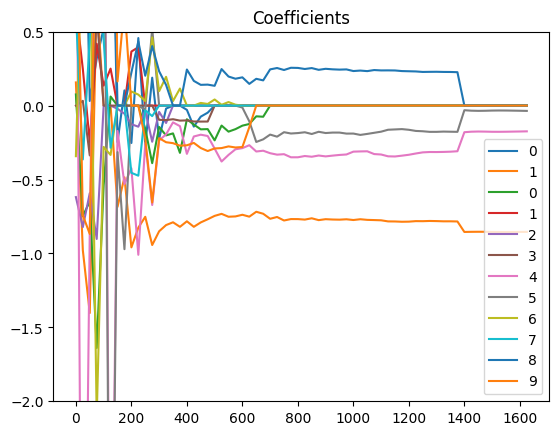

In [54]:
for key in coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()
plt.ylim([-2, 0.5])
plt.title('Coefficients')

In [55]:
unscaled_coeff_keys = [key for key in df.keys() if key.__contains__('unscaled_coeffs_output')]
print(unscaled_coeff_keys)

['unscaled_coeffs_output_0_coeff_0', 'unscaled_coeffs_output_0_coeff_1', 'unscaled_coeffs_output_0_coeff_10', 'unscaled_coeffs_output_0_coeff_11', 'unscaled_coeffs_output_0_coeff_2', 'unscaled_coeffs_output_0_coeff_3', 'unscaled_coeffs_output_0_coeff_4', 'unscaled_coeffs_output_0_coeff_5', 'unscaled_coeffs_output_0_coeff_6', 'unscaled_coeffs_output_0_coeff_7', 'unscaled_coeffs_output_0_coeff_8', 'unscaled_coeffs_output_0_coeff_9']


Text(0.5, 1.0, 'Coefficients')

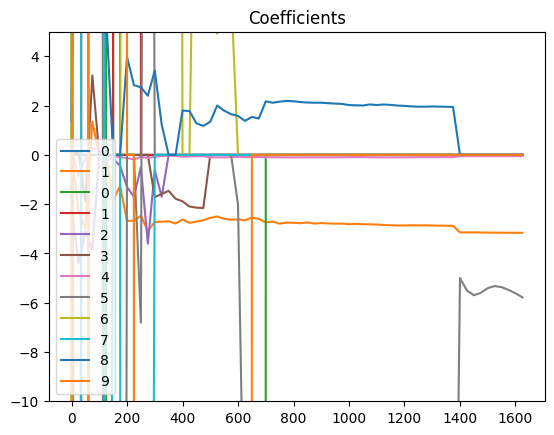

In [56]:
for key in unscaled_coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()
plt.ylim([-10, 5])
plt.title('Coefficients')

In [57]:
C_0 = df['unscaled_coeffs_output_0_coeff_0'].iloc[-1]
print('C_0 = ', C_0)
C_1 = df['unscaled_coeffs_output_0_coeff_1'].iloc[-1]
print('C_1 = ', C_1)
C_2 = df['unscaled_coeffs_output_0_coeff_2'].iloc[-1]
print('C_2 = ', C_2)
C_3 = df['unscaled_coeffs_output_0_coeff_3'].iloc[-1]
print('C_3 = ', C_3)
C_4 = df['unscaled_coeffs_output_0_coeff_4'].iloc[-1]
print('C_4 = ', C_4)
C_5 = df['unscaled_coeffs_output_0_coeff_5'].iloc[-1]
print('C_5 = ', C_5)
C_6 = df['unscaled_coeffs_output_0_coeff_6'].iloc[-1]
print('C_6 = ', C_6)
C_7 = df['unscaled_coeffs_output_0_coeff_7'].iloc[-1]
print('C_7 = ', C_7)
C_8 = df['unscaled_coeffs_output_0_coeff_8'].iloc[-1]
print('C_8 = ', C_8)
C_9 = df['unscaled_coeffs_output_0_coeff_9'].iloc[-1]
print('C_9 = ', C_9)
C_10 = df['unscaled_coeffs_output_0_coeff_10'].iloc[-1]
print('C_10 = ', C_10)
C_11 = df['unscaled_coeffs_output_0_coeff_11'].iloc[-1]
print('C_11 = ', C_11)

C_0 =  0.0
C_1 =  -3.1620423793792725
C_2 =  0.0
C_3 =  0.0
C_4 =  -0.05159977823495865
C_5 =  -5.77994441986084
C_6 =  0.0
C_7 =  0.0
C_8 =  0.0
C_9 =  0.0
C_10 =  0.0
C_11 =  0.0


In [58]:
# eqilibrate the matrix with data
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
signal_matrix_equilibrated = pd.read_csv('dataset/signal_matrix_equilibrated.csv')
plot_time_label_df = pd.read_csv('dataset/plot_time_label_df.csv')

In [61]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

signal_matrix_equilibrated_dx = signal_space_derivative(signal_matrix_equilibrated,160,20,1,15)
signal_matrix_equilibrated_dxdx = signal_space_derivative(signal_matrix_equilibrated_dx,160,20,1,15)
signal_matrix_equilibrated_dxdxdx = signal_space_derivative(signal_matrix_equilibrated_dxdx,160,20,1,15)
min_nx_dx = signal_matrix_equilibrated_dxdxdx['nx'].min()
max_nx_dx = signal_matrix_equilibrated_dxdxdx['nx'].max()
nb_nx_points = 140
signal_matrix_space = signal_x_common_base(signal_matrix_equilibrated,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dx = signal_x_common_base(signal_matrix_equilibrated_dx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dxdx = signal_x_common_base(signal_matrix_equilibrated_dxdx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_space_dxdxdx = signal_x_common_base(signal_matrix_equilibrated_dxdxdx,'nx', min_nx_dx, max_nx_dx, nb_nx_points)

signal_matrix_time = signal_matrix_space.copy()
signal_matrix_time_temporal_nx = signal_matrix_time['nx']
signal_matrix_time.drop(['nx'], axis=1, inplace=True)
signal_matrix_time = signal_matrix_time.T
signal_matrix_time.reset_index(drop=True, inplace=True)
signal_matrix_time['nt'] = plot_time_label_df.loc[:,'frame_in_hours'].values

signal_matrix_time_dt = signal_time_derivative(signal_matrix_time,160,20,1,9)
signal_matrix_time_dtdt = signal_time_derivative(signal_matrix_time_dt,160,20,1,9)
min_nt = signal_matrix_time_dtdt['nt'].min()
max_nt = signal_matrix_time_dtdt['nt'].max()
nb_nt_points = 160

signal_matrix_time_dt = signal_t_common_base(signal_matrix_time_dt, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_time_dt.drop(['nt'], axis=1, inplace=True)
signal_matrix_time_dt_transposed = signal_matrix_time_dt.T
signal_matrix_time_dt_transposed['nx'] = signal_matrix_time_temporal_nx
signal_matrix_time_dt_normal = signal_x_common_base(signal_matrix_time_dt_transposed,'nx', min_nx_dx, max_nx_dx, nb_nx_points)
signal_matrix_time_dt_normal.drop(['nx'], axis=1, inplace=True)

In [62]:
print('signal u_t shape')
print(signal_matrix_time_dt_normal.shape)
signal_matrix_space_dx_temporal = signal_matrix_space_dx.copy()
signal_matrix_space_dx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dx_temporal = signal_matrix_space_dx_temporal.T
signal_matrix_space_dx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dx_temporal = signal_t_common_base(signal_matrix_space_dx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dx_normal = signal_matrix_space_dx_temporal.T
print('signal u_x shape')
print(signal_matrix_space_dx_normal.shape)

signal_matrix_space_dxdx_temporal = signal_matrix_space_dxdx.copy()
signal_matrix_space_dxdx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dxdx_temporal = signal_matrix_space_dxdx_temporal.T
signal_matrix_space_dxdx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dxdx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dxdx_temporal = signal_t_common_base(signal_matrix_space_dxdx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dxdx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dxdx_normal = signal_matrix_space_dxdx_temporal.T
print('signal u_xx shape')
print(signal_matrix_space_dxdx_normal.shape)

signal_matrix_space_dxdxdx_temporal = signal_matrix_space_dxdxdx.copy()
signal_matrix_space_dxdxdx_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_dxdxdx_temporal = signal_matrix_space_dxdxdx_temporal.T
signal_matrix_space_dxdxdx_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_dxdxdx_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_dxdxdx_temporal = signal_t_common_base(signal_matrix_space_dxdxdx_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_dxdxdx_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_dxdxdx_normal = signal_matrix_space_dxdxdx_temporal.T
print('signal u_xxx shape')
print(signal_matrix_space_dxdxdx_normal.shape)


signal_matrix_space_temporal = signal_matrix_space.copy()
signal_matrix_space_temporal.drop(['nx'], axis=1, inplace=True)
signal_matrix_space_temporal = signal_matrix_space_temporal.T
signal_matrix_space_temporal.reset_index(drop=True, inplace=True)
signal_matrix_space_temporal['nt'] =  signal_matrix_time['nt']
signal_matrix_space_temporal = signal_t_common_base(signal_matrix_space_temporal, 'nt', min_nt, max_nt, nb_nt_points)
signal_matrix_space_temporal.drop(['nt'], axis=1, inplace=True)
signal_matrix_space_normal = signal_matrix_space_temporal.T
print('signal u shape')
print(signal_matrix_space_normal.shape)
signal_matrix_space_square_normal = signal_matrix_space_normal**2
print('signal u^2 shape')
print(signal_matrix_space_normal.shape)

signal u_t shape
(140, 160)
signal u_x shape
(140, 160)
signal u_xx shape
(140, 160)
signal u_xxx shape
(140, 160)
signal u shape
(140, 160)
signal u^2 shape
(140, 160)


In [63]:
signal_matrix_equation_normal = signal_matrix_space_dx_normal*C_1 + \
                                signal_matrix_space_dxdx_normal*C_2 + \
                                signal_matrix_space_dxdxdx_normal*C_3 + \
                                signal_matrix_space_normal*C_4 + \
                                signal_matrix_space_normal * signal_matrix_space_dx_normal*C_5 + \
                                signal_matrix_space_normal * signal_matrix_space_dxdx_normal* C_6 + \
                                signal_matrix_space_normal * signal_matrix_space_dxdxdx_normal* C_7 + \
                                signal_matrix_space_square_normal * C_8 +\
                                signal_matrix_space_square_normal * signal_matrix_space_dx_normal * C_9 + \
                                signal_matrix_space_square_normal * signal_matrix_space_dxdx_normal * C_10 + \
                                signal_matrix_space_square_normal * signal_matrix_space_dxdxdx_normal * C_11 + C_0

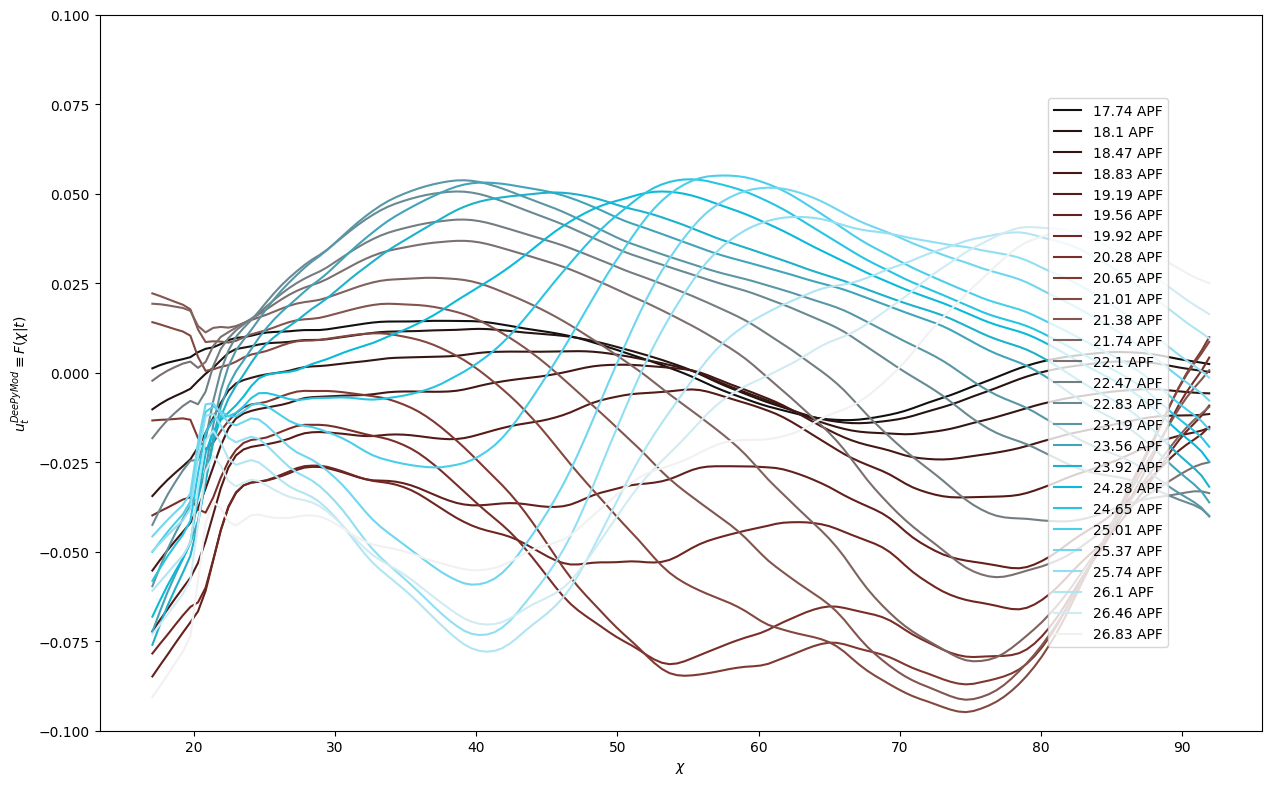

In [68]:
plot_factor = 2
ratio = 1
figure, ax = plt.subplots(figsize=(plot_factor*7.5, plot_factor*4.65), ncols = 1)
signal_matrix_space_normal_to_plot = signal_matrix_equation_normal.copy()
nx_linearized = np.linspace(min_nx_dx, max_nx_dx, nb_nx_points)
nt_linearized = np.linspace(min_nt, max_nt, nb_nt_points)
signal_matrix_space_normal_to_plot['nx'] = nx_linearized
end_frame = 130
start_frame = 1
delta_t = 5
chi_threshold = 17
derivative_label = 'u^{DeePyMod}_t'
#angle = np.round(angle, decimals = 3)
#label = '$\\theta='+ str(np.round(math.degrees(angle),decimals=1))+'^{\circ}$'
#title = 'signal ' + quantity + ', '+ label
cmap = cc.cm.CET_CBTL2
colors = cmap(np.linspace(0,1,int((end_frame  - start_frame + 1) / delta_t)))
signal = signal_matrix_space_normal_to_plot.copy()
signal = signal[(signal['nx']>chi_threshold)]
for time_frame,color in zip(range(start_frame,end_frame ,delta_t),colors):
    plt.plot(signal['nx'], signal.loc[:,time_frame],c=color,label = str(np.round(nt_linearized[time_frame],decimals = 2))+' APF')
#plt.axhline(y = 0, color = "gray", linestyle = "--", linewidth = 0.5)
ax.set(xlabel = r'$\chi$', ylabel = r'$ %s \equiv F(\chi|t)$' % derivative_label)
#xleft, xright = ax.get_xlim()
#ybottom, ytop = ax.get_ylim()
#ax.set_aspect(abs((xright-xleft)/(ybottom - ytop))*ratio)
#plt.annotate(r'%s' %title, xy=(0.03, 0.05), xycoords='axes fraction')
ax.legend(loc='center left', bbox_to_anchor=(0.81, 0.5))
ax.set_ylim([-0.1, 0.1])
#if FIGURES_DIR != '':
#    plt.savefig(os.path.join(FIGURES_DIR, slugify(title)+'.png'), format = 'png')
plt.show()